# Cube with two types of walls and feed-back indoor temperature control

Objectives:
- Physical analysis of a cube with 5 concrete walls and a glass wall
- Model a controller for indoor temperature
- Discuss the influence of the controller and of the position of the insulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical analysis and mathematical modelling

![cube](t03_cube_principle.png)
> Simple ventilated room (5 walls and 1 window) w controlled by a P-controller

Let’s consider a cubic building with an HVAC systems controolled by a P-controller.

In [2]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0

The dimension and surface areas of the building are:

In [3]:
Kp

0.001

In [4]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

The building is ventilated; the volumis air flow rate is `Va_dot`: 

In [5]:
Va = l**3           # m³ volume of air
ACH = 1             # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

The thermophysical propoerties of air:

In [6]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K

The thermophysical propoerties of the materials and surface areas of the materials in the wall:

In [7]:
wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/m.K
        'Density': [2300, 55, 2500],        # kg/m³
        'Specific heat': [880, 1210, 750],  # J/kg.K
        'Width': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Slices': [4, 2, 1]}                # number of discretizations
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete,1.400,2300,880,0.200,45,4
Insulation,0.027,55,1210,0.080,45,2
Glass,1.400,2500,750,0.004,9,1


The radiative properties of the surfaces are:

In [8]:
ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

The view factor between the wall and the window (glass) is:

In [9]:
Fwg = 1 / 5     # view factor wall - glass

The mean temperature of the surfaces (used for the linearizatio of the radiative heat exchange) is:

In [10]:
Tm = 20 + 273   # mean temp for radiative exchange

Convection coeficients:

In [11]:
# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4., 'out': 10}])

## Thermal circuit

![heat_processes](t03_heat_process.png)
> Analysis of heat processes.

![thermal_circuit](t03_therm_circ.png)
> Thermal circuit.

![thermal_circuit](t03_TCmatrices.png)
> Matrices of the Differential-algebraic system of equations

The thermal circuit is discribed by the diferential-algebraic set of equations:

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
$$q = G (-A \theta + b)$$

where:
- **A** incidence matrix: shows how the temperature nodes are conected by branches of heat flow. It consists of $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. If flow *m* enters  into the node *n*, then the element (*m, n*) is 1; if flow *m* exits from the node *n*, then the element (*m, n*) is -1; if flow *m* is not conected to node *n*, then the element (*m, n*) is 0.

- **G** conductance matrix: diagonal matrix containing the conductances. Its size is It consists of $n_q \times n_q$,  where $n_q$ is the number of flow branches.

- **b** temperature source vector: if there is no temperature source on the branch *m*, then $b_m = 0$.

- **C** capacity matrix: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- **f** heat flow source vector: if there is no heat flow source in the node *n*, then $f_n = 0$.


**Thermal coductances**

In [12]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

# Long-wave radiation exchnage
GLW1 = ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation'] * 4 * σ * Tm**3
GLW2 = Fwg * wall['Surface']['Insulation'] * 4 * σ * Tm**3
GLW3 = ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass'] * 4 * σ * Tm**3
# long-wave exg. wall-glass
GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)

# ventilation & advection
Gv = Va_dot * air['Density'] * air['Specific heat']

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

**Thermal capacities**

In [13]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va

**Incidence matrix**

In [14]:
A = np.zeros([12, 8])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 4], A[6, 6] = -1, 1
A[7, 5], A[7, 6] = -1, 1
A[8, 7] = 1
A[9, 5], A[9, 7] = 1, -1
A[10, 6] = 1
A[11, 6] = 1
np.set_printoptions(suppress=False)
print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]]


**Conductance matrix**

In [15]:
G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
             2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
             GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
             2 * G_cd['Glass'], Gv, Kp])
np.set_printoptions(precision=3, threshold=16, suppress=True)
print(G)

[[ 450.       0.       0.    ...    0.       0.       0.   ]
 [   0.     630.       0.    ...    0.       0.       0.   ]
 [   0.       0.     630.    ...    0.       0.       0.   ]
 ...
 [   0.       0.       0.    ... 6300.       0.       0.   ]
 [   0.       0.       0.    ...    0.       9.       0.   ]
 [   0.       0.       0.    ...    0.       0.       0.001]]


**Capacity matrix**

In [16]:
C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
            C['Air'], C['Glass']])
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
print(C)

[[       0.        0.        0. ...        0.        0.        0.]
 [       0. 18216000.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.        0.        0.]
 ...
 [       0.        0.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.    32400.        0.]
 [       0.        0.        0. ...        0.        0.    67500.]]


**Input vector**

The vector of *temperature sources* is **b**. It has the size of the number of branches (in this example 12) and it's element corresponding to a branch without a source is zero. If the flow in a source is from low potential to high potential (i.e. from - to +), the source is positive [🔗](https://en.wikipedia.org/wiki/Passive_sign_convention) . Let's give some arbitrary non-zero values to the temperature sources:

In [17]:
b = np.zeros(12)
b[[0, 8, 10, 11]] = 10 + np.array([0, 80, 100, 110])

The vector of *heat sources* is **f**. It has the size of the number of nodes (in this example 8) and its element corresponding to a node without a heat source is zero. Let's give some arbitrary non-zero values to the heat sources:

In [18]:
f = np.zeros(8)
f[[0, 4, 6, 7]] = 1000 + np.array([0, 4000, 6000, 7000])

The vector of outputs is **y**. It has the size of the number of nodes (in this example 8). The non-zero values of **y** indicate the nodes that are the outputs of the model. Let's assume that all temperatures are of interest:

In [19]:
y = np.ones(8)

The inputs vector **u** is:

$$\mathbf{u} = \begin{bmatrix}
\mathbf{b}\\ 
\mathbf{f}
\end{bmatrix}$$

where **b** is  the vector of temperature sources and **f** the vector of heat flow sources. Note that in Python, a vector is a row. The **u** vector is obtained as an horizontal stack of the sources that are in the circuit (non-zero elements of **b** and **f**):

In [20]:
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])
u

array([  10.,   90.,  110.,  120., 1000., 5000., 7000., 8000.])

## State-space model

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) of the dynamic model is obtained from the differential-algebraic set of equations:

In [21]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

Let's compare the steady state results obtained with the differential-algebraic equations of the thermal circuit:
$$y_{tc} = (A^T G A)^{-1}(A^T G b + f)$$
and the state-space:
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$ 

In [22]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[ 21.609  28.314  35.019 174.086 313.153 246.854 325.53  245.928]
[ 21.609  28.314  35.019 174.086 313.153 246.854 325.53  245.928]
Max error in steady-state between thermal circuit and state-space: 3.98e-13


## Dynamic simulation

In dynamic simulation, the inputs vary in time. Let's indicate the sources in the circuit by ones:

In [23]:
b = np.zeros(12)
b[[0, 8, 10, 11]] = 1

f = np.zeros(8)
f[[0, 4, 6, 7]] = 1

Let's consider that the output of the circuit is the indoor temperature (i.e. the temperature of node 6):

In [24]:
y = np.zeros(8)
y[[6]] = 1

The state-space representation is obtained from the differential-algebraic equations of the thermal circuit:

In [25]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

### Time step

The maximum time step for numerical stability of Euler explicit itegration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t \leq -2 / \min \lambda_i = \min T_i/2$$

where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [26]:
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 479.08 s


The maximum time step for numerical stability of Euler explicit integration in time depends on the value of the P-controller gain and if the capacities of the indoor air and window glass are taken into account. 

For example
- if `Kp = 1e4` (i.e. powerful P-controller) and `C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, C['Air'], C['Glass']])`, the maximum time step is `6.42 s`.
- if `Kp = 1e-3` (i.e. practically free floating building) and `C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])`, the maximum time step is `10029.45 s`.

Let's chose a time step smaller than `dtmax`:

In [27]:
# dt = 5
dt = 360

### Step response

Let's obtain the dynamic response of the system to a step input. For the duration of simulation:

In [28]:
duration = 3600 * 24 * 2        # [s]

the number of steps is

In [29]:
n = int(np.floor(duration / dt))

The time vector (with time step `dt`) is

In [30]:
t = np.arange(0, n * dt, dt)    # time

For the input vector **u**, the outdoor temperatures will be `To = 1`, the indoor set-point temperature will `Tsp =0`, and the heat flow sources will be zero. 

In [31]:
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
u = np.zeros([8, n])
u[0:3, :] = np.ones([3, n])

The vectors for the evolution of **tem**peratures (states) in time for Euler **exp**licit and **imp**licit are:

In [32]:
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

By integrating the state-space model
$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$
by using Euler forward (or explicit)
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and Euler backward (or implicit) integration
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [33]:
I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

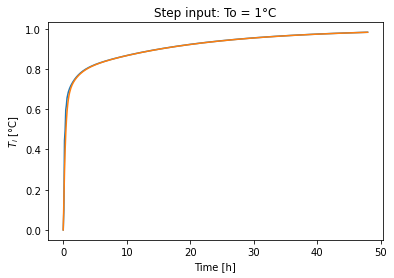

In [34]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()

In [35]:
b = np.zeros(12)
b[[0, 8, 10]] = 1
f = np.zeros(8)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input:0.9827 °C


### Simulation with weather data

Read the hourly weather data file from start date to end date. The data are for a year (the choice of 2000 for the year is arbitrary).

In [36]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

From weather data, calculate the hourly solar radiation on a tilted surface, `Φt1` [W]:

In [37]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

The weather data is at the time-step of 1h. It needs to be at time step of `dt`. 

In [38]:
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

Let's consider the indoor temperature setpoint `Ti` and auxiliary heat flow `Qa` constant for the whole simulation period.

In [39]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

The simulation time vector, at time step `dt`is:

In [40]:
t = dt * np.arange(data.shape[0])

The input vector is formed by the temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]$ and the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]$

In [41]:
u = pd.concat([data['To'], data['To'], data['To'], data['Ti'],
               α_wSW * wall['Surface']['Concrete'] * data['Φt1'],
               τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φt1'],
               data['Qa'],
               α_gSW * wall['Surface']['Glass'] * data['Φt1']], axis=1)

The initial value of the state-vector can be different of zero:

In [42]:
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

Explicit Euler integration in time
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$

In [43]:
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):
$$y = C_s \theta + D_s u$$
and the variation of the heat flow of the HVAC system:
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

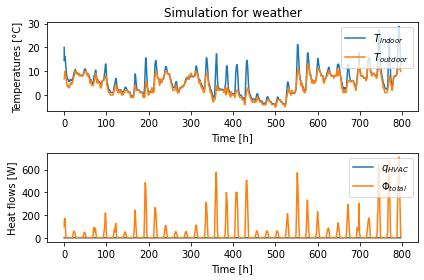

In [44]:
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

## Discussion

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then,the controller is inefffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and $C_g =$ `C['Glass']`are considered, then the time step is small;
    - if the capacities of the air and of the glas are zero, then the time step is large.

The controller models an HVAC system capable to heat (when $q_{HVAC} > 0$) and to cool $q_{HVAC} < 0$).

**References**

C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024